# **Reference**
**아래 코드는 https://github.com/lukemelas/Automatic-Image-Colorization/ 의 코드를 바탕으로하여 만든 코드입니다.**

# **0. Basics**
해당 코드를 돌리기 위한 기본적인 사항들 입니다.

(Ex : import module, 구글드라이브 마운트, 변수선언, 유용한 함수선언 등)

In [1]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For image processing
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time, sys
# Too ignore warning
import warnings
warnings.simplefilter("ignore", UserWarning)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_losses = 1e+6 # lowest validation loss
current_epoch = 0  # start from epoch 0 or last checkpoint epoch
train_loss_list = [] # training loss list
val_loss_list = [] # validation loss list
lr_list = [] # learning rate list
if torch.cuda.is_available():
  print("현재 사용중인 GPU : {}".format(torch.cuda.get_device_name(0)))
else:
  print("현재 GPU를 사용하고 있지 않습니다.")

현재 사용중인 GPU : GeForce GTX 1060 6GB


In [0]:
# 구글 드라이브 마운트 - 이하 코드는 구글 코랩에서 작업하기 위한 코드들입니다. 로컬에서 작업하실거면 무시하셔도 됩니다.
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/딥러닝의 기초/Project")
sys.path.append('/content/drive/My Drive/Colab Notebooks/딥러닝의 기초/Project')
# 위의 Root부분은 개개인마다 다르므로 직접 수정해주셔야 합니다. main.ipynb파일이 있는 경로로 지정해주시면 됩니다.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 유용한 함수들입니다.
class AverageMeter(object):
    '''A handy class from the PyTorch ImageNet tutorial''' 
    def __init__(self):
        self.reset()
    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
    '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
    plt.clf() # clear matplotlib 
    color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
    color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
    color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
    color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
    color_image = lab2rgb(color_image.astype(np.float64))
    grayscale_input = grayscale_input.squeeze().numpy()
    if save_path is not None and save_name is not None: 
        plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
        plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))
    else:
        return color_image

# **1. Loading dataset**

## 1.1 Custom Dataset

지정된 경로에 있는 모든 이미지를 갖고있는 객체를 만드는 클래스입니다. 예를들어



```
train_imagefolder = GrayscaleImageFolder('./dataset/train/', train_transforms)
```

위 코드는 './dataset/train/(아무폴더)'디렉토리에 있는 모든 이미지를 모은 객체를 생성합니다.

이때 우리가 불러오고자하는 이미지들은 반드시 train폴더가 아닌 train폴더안의 (아무폴더)에 들어있어야 합니다.


한편 transforms는 Data augmentation을 적용하기 위한 argument입니다. 


```
train_imagefolder[idx]
```
위 코드는 해당 객체의 idx번째 이미지로부터 (Grayscale된 이미지), (ab 이미지), (원본 이미지)를 반환합니다.



In [3]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
        img = self.transform(img)
    img = np.asarray(img)
    img_lab = rgb2lab(img)
    img_lab = (img_lab + 128) / 255
    img_ab = img_lab[:, :, 1:3]
    img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
    img_gray = rgb2gray(img)
    img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()
    if self.target_transform is not None:
        target = self.target_transform(target)
    return img_gray, img_ab, img

## 1.2 Data Augmentation & Loading

Data Augmentation(데이터 증강)을 적용하고 데이터를 로드하는 코드입니다. 
Data Augmentation은 transform_augmentation을 수정하여 바꿀 수 있습니다. 예를들어



```
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip()])
```
위 코드는

(1) 원본 이미지에서 256 * 256 만큼 Randomcrop하고

(2) 일정확률로 위 아래를 뒤집기

하는 역할을 합니다.

Pytorch에서 기본적으로 지원하는 Augmentation 기법들은 https://pytorch.org/docs/stable/torchvision/transforms.html 에서 확인할 수 있습니다.

In [4]:
# Training
print('Loading Training data...', end=' ')
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop((256, 256), scale=(0.25, 1.0)),
    transforms.ColorJitter(brightness=0.3,contrast=0.3, saturation=0.3),
    transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('../dataset/flower102/train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)
print("Done!")
print("Training data size : {}".format(len(train_imagefolder)))

# Validation 
print('Loading Validation data...', end=' ')
val_transforms = transforms.Compose([
    transforms.Resize((256,256)),])
val_imagefolder = GrayscaleImageFolder('../dataset/flower102/val', val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)
print("Done!")
print("Training data size : {}".format(len(val_imagefolder)))

Loading Training data... Done!
Training data size : 6552
Loading Validation data... Done!
Training data size : 818


## 1.3 Dataset Test

Dataset이 성공적으로 만들어졌는지 확인하는 코드입니다.
좌측 이미지가 원본이고 우측 이미지는 Grayscale 결과입니다.

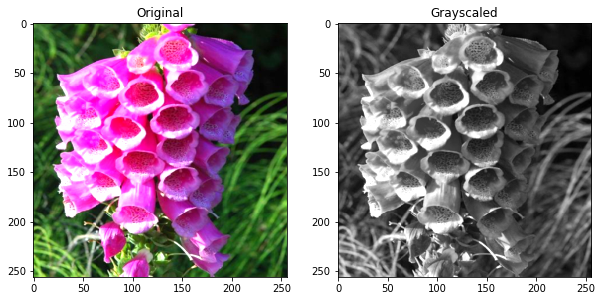

In [6]:
import random

i = random.randint(0, len(train_imagefolder))
temp_gray, temp_ab, temp_label = train_imagefolder[i]

plt.subplot(121)
plt.imshow(temp_label)
plt.title('Original')

plt.subplot(122)
plt.imshow(temp_gray.squeeze(), cmap='gray')
plt.title('Grayscaled')
plt.rcParams["figure.figsize"] = (10,5)

plt.show()

# **2. Construct the Model**

학습에 쓸 모델에 해당하는 코드입니다.

현재 프로토타입으로 쓰인 모델은 (인풋)-(인코더)-(디코더)-(아웃풋)으로 구성되어 있습니다.

인풋은 Grayscaled Image를 나타내는 1 * 256 * 256 의 Tensor입니다.

인코더는 1개 채널의 Input Tensor를 512개 채널을 가진 Feature Tensor로 변환하며 이 모델에서는 Resnet18을 사용하였습니다.

참고로 인코더가 Feature 추출을 더 잘하기 위해서, 먼저 Flower102 데이터셋에 대한 분류기로 Pre-train시켰습니다. 
(Validation Accuracy 89.120%)

디코더는 Feature Tensor를 다시 2 * 256 * 256 의 Output Tensor로 변환하며 Convolutional Layer와 Upsampling Layer로 구성되어있습니다.

## 2.1 Resnet

Encoder로 쓰일 Resnet Class입니다.

In [7]:
# Resnet
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x

    # Allow for accessing forward method in a inherited class
    forward = _forward


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

## 2.2 ColorizationNet

Input이 통과할 전체 모델입니다.

In [8]:
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        class Encoder(nn.Module):
            def __init__(self):
                super(Encoder, self).__init__()
                # Build ResNet and change first conv layer to accept single-channel input
                self.resnet = resnet18()
                self.resnet.conv1.weight = nn.Parameter(self.resnet.conv1.weight.sum(dim=1).unsqueeze(1).data)

            def forward(self, input_image):
                # Pass input through ResNet-gray to extract features
                output = self.resnet(input_image)
                return output

        class Decoder(nn.Module):
            def __init__(self):
                super(Decoder, self).__init__()
                # Fusion layer to combine midlevel and global features

                # Convolutional layers and upsampling
                self.conv1 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
                self.bn1 = nn.BatchNorm2d(256)
                self.conv2 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
                self.bn2 = nn.BatchNorm2d(128)
                self.conv3 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
                self.bn3 = nn.BatchNorm2d(64)
                self.conv4 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
                self.bn4 = nn.BatchNorm2d(32)     
                self.conv5 = nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1)
                self.bn5 = nn.BatchNorm2d(2)                
                                          
                self.upsample = nn.Upsample(scale_factor=2)

            def forward(self, midlevel_input): #, global_input):
                # Convolutional layers and upsampling
                x = self.upsample(midlevel_input)
                x = F.relu(self.bn1(self.conv1(x)))
                x = self.upsample(x)
                x = F.relu(self.bn2(self.conv2(x)))
                x = self.upsample(x)
                x = F.relu(self.bn3(self.conv3(x)))
                x = self.upsample(x)
                x = F.relu(self.bn4(self.conv4(x)))
                x = self.upsample(x)
                x = F.sigmoid(self.bn5(self.conv5(x)))
                return x
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, input):
        encode = self.encoder(input)
        output = self.decoder(encode)

        return output

model = ColorizationNet()
model = model.to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

Number of parameters: 12738982


# **3. Save / Load the model**

## 3.1 Save the model
./checkpoint/ 디렉토리에 현재 모델을 'ckpt.pth'파일로 저장합니다.

In [9]:
def save(model, epoch, best_losses):
    global train_loss_list, val_loss_list, lr_list
    print('Saving...', end=' ')
    state = {
        'state_dict': model.state_dict(),
        'epoch': epoch,
        'best_losses' : best_losses,
        'train_loss_list' : train_loss_list,
        'val_loss_list' : val_loss_list,
        'lr_list' : lr_list,
        }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.pth')
    print("Done!")

In [11]:
print("Current epoch : {}, Current best_losses : {}".format(current_epoch, best_losses))
save(model, current_epoch, best_losses)

Current epoch : 0, Current best_losses : 1000000.0
Saving... Done!


## 3.2 Load the model
./checkpoint/ 디렉토리에 현재 모델을 'ckpt.pth'파일을 불러옵니다.

In [10]:
def load(model):
    global current_epoch, best_losses, train_loss_list, val_loss_list, lr_list
    print('Loading...', end=' ')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    model.load_state_dict(checkpoint['state_dict'])
    current_epoch = checkpoint['epoch']
    best_losses = checkpoint['best_losses']
    train_loss_list = checkpoint['train_loss_list'] 
    val_loss_list = checkpoint['val_loss_list']
    lr_list = checkpoint['lr_list']
    model.eval()
    print("Done!")

In [11]:
load(model)
print("Current epoch : {}, Current best_losses : {}".format(current_epoch, best_losses))

Loading... Done!
Current epoch : 21, Current best_losses : 0.0058896941005327445


## 3.3 Load the pre-trained encoder

미리 학습된 encoder를 가져옵니다.

In [23]:
def encoder_load(model):
    global current_epoch, best_losses, train_loss_list, val_loss_list
    print('Loading...', end=' ')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/encoder/flower102_resnet18_91.076.pth')
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    model.eval()
    print("Done!")
    
encoder_load(model.encoder)

Loading... Done!


# **4. Train the Model**

## 4.1 Set hyperparameters, optimizer, loss, etc.

하이퍼파라미터, Loss Function, 옵티마이저, epoch 등을 결정합니다.

In [12]:
epoch_num = 30 # 반복할 epoch 수
learning_rate = 0.01 # learning rate
criterion = nn.MSELoss() # Loss 함수 
# MSE로하면 학습할때 회색조로 학습되는 문제가 있습니다. 아무래도 Loss를 다른걸로 써야할 것 같습니다.
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-5, nesterov=True) # 옵티마이저
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=32, shuffle=True) # 배치사이즈

## 4.2 Train and validate the model

모델을 트레이닝하여 매 에폭마다 Validation Loss를 측정합니다.

만약 Validation Loss가 최저값으로 갱신되면 모델을 저장합니다.

In [13]:
# training function
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()

    # Prepare value counters and timers
    batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()
    for i, (input_gray, input_ab, input_label) in enumerate(train_loader):

        # Use GPU if available
        input_gray = input_gray.to(device)
        input_ab = input_ab.to(device)
        input_label = input_label.to(device)
        criterion = criterion.to(device)

        # Record time to load data (above)
        data_time.update(time.time() - end)

        # Run forward pass
        output_ab = model(input_gray) 
        loss = criterion(output_ab, input_ab) 
        losses.update(loss.item(), input_gray.size(0))

        # Compute gradient and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record time to do forward and backward passes
        batch_time.update(time.time() - end)
        end = time.time()

        # Print model accuracy -- in the code below, val refers to value, not validation
        print('\rEpoch: [{0}]\t Batch:[{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.6f} ({loss.avg:.6f})\t'.format(
            epoch, i+1, len(train_loader), batch_time=batch_time,
            data_time=data_time, loss=losses), end='') 
        
    # record the loss
    train_loss_list.append(losses.avg)
    lr_list.append(learning_rate)
        
    print()

In [14]:
# validation funciton
def validate(val_loader, model, criterion, epoch, save = False):
    with torch.no_grad():
        # Prepare value counters and timers
        batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

        end = time.time()
        already_saved_images = False
        for i, (input_gray, input_ab, target) in enumerate(val_loader):
            data_time.update(time.time() - end)

            # Use GPU if available
            input_gray = input_gray.to(device)
            input_ab = input_ab.to(device)
            criterion = criterion.to(device)

            # Run model and record loss
            output_ab = model(input_gray) # throw away class predictions
            loss = criterion(output_ab, input_ab)
            losses.update(loss.item(), input_gray.size(0))

            # Save images to file
            if save is True:
                for j in range(5): # save at most 5 images
                    save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
                    save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
                    to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

            # Record time to do forward passes and save images
            batch_time.update(time.time() - end)
            end = time.time()

            # Print model accuracy -- in the code below, val refers to both value and validation
            print('\rValidate: [{0}/{1}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Loss {loss.val:.6f} ({loss.avg:.6f})\t'.format(
                 i+1, len(val_loader), batch_time=batch_time, loss=losses), end='')
        
    # Record the validation loss
    val_loss_list.append(losses.avg)
    print()

    return losses.avg

In [ ]:
# Train model
for epoch in range(current_epoch, current_epoch + epoch_num):
    # Train for one epoch, then validate
    print('Learning rate = {}'.format(learning_rate))
    model.train()
    train(train_loader, model, criterion, optimizer, epoch)
    current_epoch += 1
    with torch.no_grad():
        model.eval()
        losses = validate(val_loader, model, criterion, epoch, save = True)
        # Save checkpoint and replace old best model if current model is better
        if losses < best_losses:
            best_losses = losses
            save(model, current_epoch, best_losses)
    print('=================================================================================================')
    
print('Done')

Learning rate = 0.01
Epoch: [21]	 Batch:[14/205]	Time 1.260 (1.191)	Data 1.140 (1.073)	Loss 0.007560 (0.006491)	

## 5.1 Test an image

Validation 결과 이미지를 출력합니다. 좌측이 원본, 가운데가 Colorization, 오른쪽이 Grayscaled 입니다.

(또는 ./outputs/color 에서 확인할 수 있습니다.)

# **5. Show the results**

In [15]:
# output이 저장될 디랙토리 생성
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)

In [16]:
# 테스트 데이터셋 로드
print('Loading test data...', end=' ')
test_transforms = transforms.Compose([
    transforms.Resize((256,256)),])
test_imagefolder = GrayscaleImageFolder('../dataset/flower102/test', test_transforms)
test_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)
print("Done!")
print("Test data size : {}".format(len(test_imagefolder)))


Loading test data... Done!
Test data size : 167


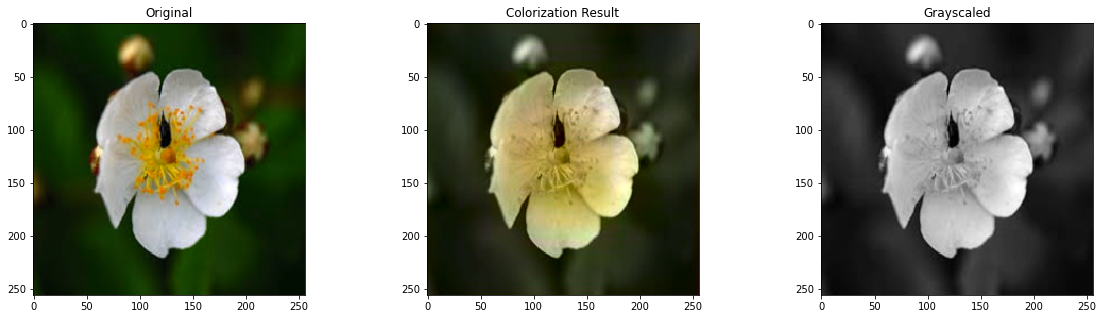

In [31]:
# Test
with torch.no_grad():
    i = random.randint(0, len(test_imagefolder))
    temp_gray, temp_ab, temp_label = test_imagefolder[i]
    temp_gray = temp_gray.unsqueeze(0).float()
    temp_gray = temp_gray.to(device)
    temp_ap = temp_ab.to(device)
    
    output_ab = model(temp_gray).squeeze().detach().cpu()
    temp_gray = temp_gray[0].cpu()
    temp_ab = temp_ab.detach().cpu()
    
    input_image = torch.cat((temp_gray, temp_ab), 0).numpy()
    input_image = input_image.transpose((1, 2, 0))
    input_image[:, :, 0:1] = input_image[:, :, 0:1] * 100
    input_image[:, :, 1:3] = input_image[:, :, 1:3] * 255 - 128   
    input_image = lab2rgb(input_image.astype(np.float64))
    
    output_image = torch.cat((temp_gray, output_ab), 0).numpy()
    output_image = output_image.transpose((1, 2, 0))
    output_image[:, :, 0:1] = output_image[:, :, 0:1] * 100
    output_image[:, :, 1:3] = output_image[:, :, 1:3] * 255 - 128   
    output_image = lab2rgb(output_image.astype(np.float64))

    plt.subplot(131)
    plt.imshow(input_image)
    plt.title('Original')

    plt.subplot(132)
    plt.imshow(output_image)
    plt.title('Colorization Result')

    plt.subplot(133)
    plt.imshow(temp_gray[0], cmap='gray')
    plt.title('Grayscaled')
    
    plt.rcParams["figure.figsize"] = (20,5)
    plt.show()


## **5.2 Plot the result**

Training Loss와 Validation Loss를 출력합니다.

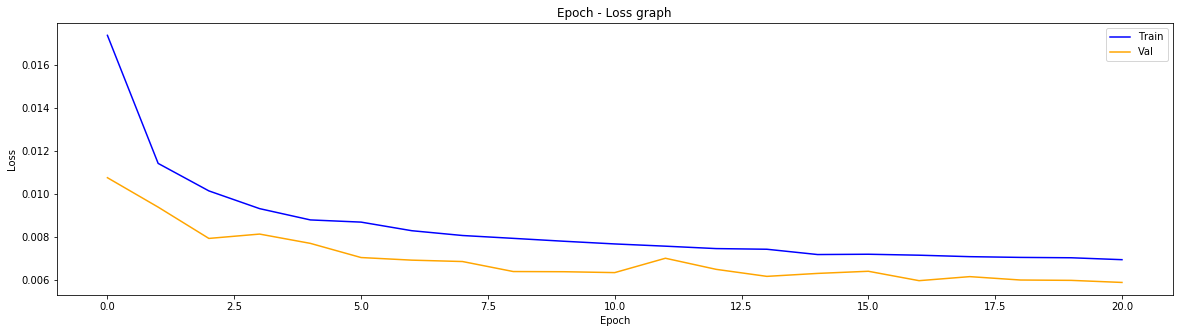

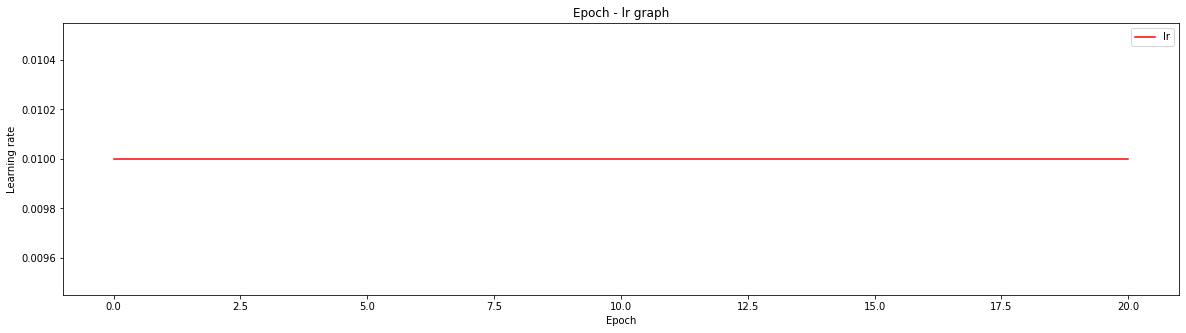

In [35]:
plt.plot(train_loss_list, color = 'blue')
plt.plot(val_loss_list, color = 'orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch - Loss graph')
plt.legend(['Train', 'Val'])

plt.show()

plt.plot(lr_list, color = 'red')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.title('Epoch - lr graph')
plt.legend(['lr'])
plt.show()

# **6. Others**


## 6.1 Initialize record and model

current_epoch, best_losses, model을 초기화합니다.

In [45]:
current_epoch = 0
best_losses = 100000
model = ColorizationNet()
model.to(device)

ColorizationNet(
  (encoder): Encoder(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Ba

In [36]:
train_loss_list = []
val_loss_list = []
lr_list = []

## 6.3 참고자료
[1] Colorful Image Colorization Richard Zhang, Phillip Isola, Alexei A. Efros 
(Submitted on 28 Mar 2016 (v1), last revised 5 Oct 2016 (this version, v5))
https://arxiv.org/abs/1603.08511

[2] Deep Colorization, Zezhou Cheng, Qingxiong Yang, Bin Sheng
(Submitted on 30 Apr 2016)
https://arxiv.org/abs/1605.00075

[3] Auto Colorization of Black and White Images using Machine Learning “Auto-encoders” technique https://medium.com/@mahmoudeljiddawi/auto-colorization-of-black-and-white-images-using-machine-learning-auto-encoders-technique-a213b47f7339

[4] Automatic image colorization with a deep convolutional neural network https://github.com/lukemelas/Automatic-Image-Colorization/